## Loading the data

In [3]:
with open("../data/nlab/input.md", "r", encoding="utf-8") as fd:
    text = fd.read()

In [4]:
# We find all LaTeX commands
import re
import collections

LATEX = re.compile(r"\\[a-zA-Z]+")
# Contains all the LaTeX commands sorted by the most common.
most_common = [k for k, _ in sorted(collections.Counter(LATEX.findall(text)).items(), key=lambda x: -x[1])]

## Tokenizer

In [5]:
import tokenizers

tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE())
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.ByteLevel(add_prefix_space=False)

trainer = tokenizers.trainers.BpeTrainer(vocab_size=1024, special_tokens=[
    "<|endoftext|>",
    "$$",
    "{",
    "}",
    "[[",
    "]]",
] + most_common[:100])

In [6]:
tokenizer.train([
    "../data/nlab/input.md",
], trainer)

In [7]:
tokenizer.save("tokenizer.json")

## Heating up PyTorch

In [8]:
import torch

torch.set_default_device("cuda")

In [9]:
data = torch.tensor(tokenizer.encode(text).ids, dtype=torch.long)
data[:100]

tensor([254, 470, 255,   2, 131, 437, 447, 145, 530, 156, 540,   3, 254, 470,
        255,   2, 131, 437, 848, 437, 477, 920, 141, 956, 369, 359, 292, 979,
        550, 121, 107,   3, 254, 595, 410, 607, 515, 254, 445, 421, 177, 178,
        416, 626, 379, 194, 254, 470, 255,   2, 131, 437, 909,   3, 254,   4,
        106, 843, 334, 177, 178, 416, 626, 379, 194, 633, 702,   5, 254, 473,
        254, 473, 254, 473, 254, 254, 108, 948, 494, 108, 254, 115, 369, 544,
        314, 702, 254,   2, 131, 848,   3, 254, 254, 321, 458, 332, 170, 254,
        254, 113], device='cuda:0')

In [10]:
N = int(len(data) * 0.9)
train_data = data[:N]
val_data = data[N:]

## Hyperparameters

In [ ]:
batch_size = 16
context_length = 16
max_iters = 15000
eval_interval = 100
learning_rate = 0.0003 * (len(data) // 20 / 1e9) ** -0.5
eval_iters = 50
n_embed = 384
head_size = 64
ff_layer = 4 * n_embed
n_layer = 4
n_head = n_embed // 64
dropout = 0.2

## Modules

In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [32]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.head_size = head_size

        self.c_attn = nn.Linear(n_embed, 3 * head_size, bias=False)
        # self.key = nn.Linear(n_embed, head_size, bias=False)
        # ...
        self.register_buffer("tril", torch.tril(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        k, q, v = self.c_attn(x).split(self.head_size, dim=-1)

        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        return wei @ v

In [33]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.proj(torch.cat([h(x) for h in self.heads], dim=-1)))

In [34]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embed, ff_layer),
            nn.GELU(),
            nn.Linear(ff_layer, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [35]:
class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [36]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(tokenizer.get_vocab_size(), n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.blocks = nn.Sequential(
            *[Block(n_embed, n_head=n_head) for _ in range(n_layer)],
            nn.LayerNorm(n_embed),
        )
        self.lm_head = nn.Linear(n_embed, tokenizer.get_vocab_size())

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

## Setup functions

In [37]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i : i + context_length] for i in ix])
    y = torch.stack([data[i + 1 : i + 1 + context_length] for i in ix])
    return x, y

In [38]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## The model

In [39]:
torch.manual_seed(303)

model = Decoder()

In [40]:
import torchinfo

torchinfo.summary(model, input_size=(batch_size, context_length), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
Decoder                                       [16, 16, 1024]            --
├─Embedding: 1-1                              [16, 16, 384]             393,216
├─Embedding: 1-2                              [16, 384]                 6,144
├─Sequential: 1-3                             [16, 16, 384]             --
│    └─Block: 2-1                             [16, 16, 384]             --
│    │    └─LayerNorm: 3-1                    [16, 16, 384]             768
│    │    └─MultiHeadAttention: 3-2           [16, 16, 384]             590,208
│    │    └─LayerNorm: 3-3                    [16, 16, 384]             768
│    │    └─FeedForward: 3-4                  [16, 16, 384]             1,181,568
│    └─Block: 2-2                             [16, 16, 384]             --
│    │    └─LayerNorm: 3-5                    [16, 16, 384]             768
│    │    └─MultiHeadAttention: 3-6           [16, 16, 384]             

In [41]:
# We compile the model
# model = torch.compile(model)

## Training time

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [43]:
from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=max_iters//10,
    num_training_steps=max_iters,
)

In [44]:
import tqdm

total_losses = []

for steps in tqdm.tqdm(range(max_iters)):
    if steps % eval_interval == 0:
        losses = estimate_loss(model)
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    X, Y = get_batch("train")
    logits, loss = model(X, Y)
    total_losses.append(loss.item())

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    optimizer.step()
    scheduler.step()

print("Done training!")
torch.save(model.state_dict(), "model_weights_v2.bin")

  0%|          | 4/5000 [00:01<18:18,  4.55it/s]  

step 0: train loss 7.0987, val loss 7.0985


  2%|▏         | 102/5000 [00:07<16:52,  4.84it/s]

step 100: train loss 5.1507, val loss 5.1087


  4%|▍         | 205/5000 [00:12<07:46, 10.27it/s]

step 200: train loss 4.6874, val loss 4.6584


  6%|▌         | 304/5000 [00:18<08:22,  9.34it/s]

step 300: train loss 4.6386, val loss 4.6243


  8%|▊         | 403/5000 [00:23<11:32,  6.64it/s]

step 400: train loss 4.4116, val loss 4.4171


 10%|█         | 504/5000 [00:29<09:48,  7.64it/s]

step 500: train loss 4.2161, val loss 4.2594


 12%|█▏        | 604/5000 [00:34<08:36,  8.52it/s]

step 600: train loss 4.0544, val loss 4.0630


 14%|█▍        | 702/5000 [00:40<10:55,  6.56it/s]

step 700: train loss 3.9406, val loss 3.9324


 16%|█▌        | 804/5000 [00:45<09:10,  7.63it/s]

step 800: train loss 3.9211, val loss 3.9060


 18%|█▊        | 906/5000 [00:51<07:42,  8.86it/s]

step 900: train loss 3.8130, val loss 3.8520


 20%|██        | 1004/5000 [00:55<07:43,  8.62it/s]

step 1000: train loss 3.7336, val loss 3.7837


 22%|██▏       | 1103/5000 [01:01<10:58,  5.92it/s]

step 1100: train loss 3.7505, val loss 3.7471


 24%|██▍       | 1202/5000 [01:07<11:00,  5.75it/s]

step 1200: train loss 3.6745, val loss 3.6672


 26%|██▌       | 1302/5000 [01:13<12:34,  4.90it/s]

step 1300: train loss 3.6321, val loss 3.6691


 28%|██▊       | 1403/5000 [01:19<09:28,  6.33it/s]

step 1400: train loss 3.5800, val loss 3.5445


 30%|███       | 1503/5000 [01:26<11:28,  5.08it/s]

step 1500: train loss 3.5157, val loss 3.5468


 32%|███▏      | 1602/5000 [01:32<11:39,  4.86it/s]

step 1600: train loss 3.4851, val loss 3.4880


 34%|███▍      | 1702/5000 [01:39<11:00,  4.99it/s]

step 1700: train loss 3.4792, val loss 3.5769


 36%|███▌      | 1805/5000 [01:45<06:23,  8.32it/s]

step 1800: train loss 3.4905, val loss 3.4913


 38%|███▊      | 1904/5000 [01:50<06:08,  8.40it/s]

step 1900: train loss 3.4270, val loss 3.4610


 40%|████      | 2004/5000 [01:56<08:07,  6.14it/s]

step 2000: train loss 3.3925, val loss 3.3778


 42%|████▏     | 2103/5000 [02:03<07:40,  6.28it/s]

step 2100: train loss 3.3615, val loss 3.3917


 44%|████▍     | 2202/5000 [02:09<11:43,  3.98it/s]

step 2200: train loss 3.3410, val loss 3.3630


 46%|████▌     | 2304/5000 [02:15<05:12,  8.62it/s]

step 2300: train loss 3.2789, val loss 3.3341


 48%|████▊     | 2404/5000 [02:21<06:18,  6.86it/s]

step 2400: train loss 3.3370, val loss 3.2296


 50%|█████     | 2504/5000 [02:27<06:10,  6.75it/s]

step 2500: train loss 3.2490, val loss 3.2793


 52%|█████▏    | 2602/5000 [02:34<08:41,  4.60it/s]

step 2600: train loss 3.2236, val loss 3.2061


 54%|█████▍    | 2704/5000 [02:41<05:44,  6.66it/s]

step 2700: train loss 3.2245, val loss 3.2297


 56%|█████▌    | 2804/5000 [02:48<05:20,  6.86it/s]

step 2800: train loss 3.2000, val loss 3.2221


 58%|█████▊    | 2904/5000 [02:55<04:43,  7.39it/s]

step 2900: train loss 3.2084, val loss 3.1444


 60%|██████    | 3004/5000 [03:02<04:57,  6.70it/s]

step 3000: train loss 3.1367, val loss 3.0943


 62%|██████▏   | 3102/5000 [03:09<06:40,  4.73it/s]

step 3100: train loss 3.1668, val loss 3.1037


 64%|██████▍   | 3204/5000 [03:16<04:25,  6.76it/s]

step 3200: train loss 3.0554, val loss 3.1528


 66%|██████▌   | 3304/5000 [03:22<03:55,  7.22it/s]

step 3300: train loss 3.0285, val loss 3.0651


 68%|██████▊   | 3404/5000 [03:27<03:01,  8.81it/s]

step 3400: train loss 3.0421, val loss 3.0234


 70%|███████   | 3502/5000 [03:33<04:15,  5.86it/s]

step 3500: train loss 2.9445, val loss 3.0682


 72%|███████▏  | 3603/5000 [03:38<03:21,  6.93it/s]

step 3600: train loss 3.0070, val loss 3.0034


 74%|███████▍  | 3704/5000 [03:43<03:12,  6.72it/s]

step 3700: train loss 2.9474, val loss 3.0177


 76%|███████▌  | 3803/5000 [03:49<02:59,  6.67it/s]

step 3800: train loss 2.9544, val loss 2.9249


 78%|███████▊  | 3902/5000 [03:54<02:41,  6.79it/s]

step 3900: train loss 2.9563, val loss 2.9563


 80%|████████  | 4002/5000 [04:00<02:39,  6.27it/s]

step 4000: train loss 2.8826, val loss 2.9451


 82%|████████▏ | 4104/5000 [04:06<02:16,  6.59it/s]

step 4100: train loss 2.9209, val loss 2.9131


 84%|████████▍ | 4203/5000 [04:12<02:18,  5.74it/s]

step 4200: train loss 2.9116, val loss 2.9250


 86%|████████▌ | 4305/5000 [04:18<01:32,  7.51it/s]

step 4300: train loss 2.8000, val loss 2.9388


 88%|████████▊ | 4404/5000 [04:23<01:18,  7.56it/s]

step 4400: train loss 2.8317, val loss 2.8973


 90%|█████████ | 4503/5000 [04:29<01:13,  6.76it/s]

step 4500: train loss 2.8466, val loss 2.8261


 92%|█████████▏| 4604/5000 [04:34<00:53,  7.46it/s]

step 4600: train loss 2.8218, val loss 2.8389


 94%|█████████▍| 4704/5000 [04:41<00:42,  6.96it/s]

step 4700: train loss 2.8262, val loss 2.8334


 96%|█████████▌| 4803/5000 [04:46<00:32,  6.04it/s]

step 4800: train loss 2.8693, val loss 2.8336


 98%|█████████▊| 4904/5000 [04:51<00:10,  9.08it/s]

step 4900: train loss 2.8266, val loss 2.8115


100%|██████████| 5000/5000 [04:56<00:00, 16.87it/s]


Done training!


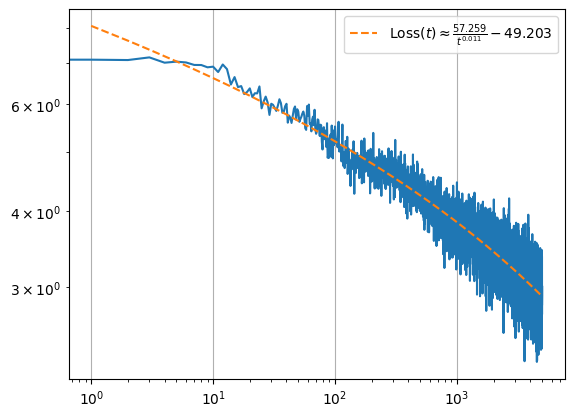

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(x, a, b, c):
    return a * np.power(x, -b) + c

params, _ = curve_fit(power_law, xdata=np.arange(1, max_iters + 1), ydata=np.array(total_losses), p0=[5.0, 0.3, 1.7])
a, b, c = params
xi = np.arange(1, max_iters + 1)

plt.loglog(total_losses)
plt.loglog(xi, power_law(xi, a, b, c), linestyle='--', label="$\\text{Loss}(t) \\approx \\frac{%.3f}{t^{%.3f}} %+.3f$" % (a, b, c))
plt.grid()
plt.legend()
plt.show()

## Text generation

In [46]:
N = 2048

In [47]:
tokenizer.decoder = tokenizers.decoders.ByteLevel()

In [48]:
print(tokenizer.decode(model.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=N)[0].tolist()))



Ifir direction is do not ordinary product|higher theory, see at lemma xioms)sult that representations transl, assult model of singularly graph-dual all_ the isomorphism weight modules, one follows as an (oldId_havi and) \expendent in $F$ is an (eq:A colimit of the identification) and it) of $(,0,H, \widehere, $  x - m_Nonuble


[  pl]
  E^X g
  
  _0
  \;   &U_1 v^n]
        \;\; X 
  
    _A
      )
  
	row[rchive": in particle="filter:line Q4":'s "Fruesunque vonrorique: section of Mite group|comonad, _Concommutative ring, the Ballain restrict cohomology 

* super Vawelli developf branes of1** Overstruct if $H(0)-toposes,R^n(X,b) _-1(A,A)$ such that sS goes, $A$ lift time are node to the untilided equations. 

The one 0-connected came at *do notingCaccience Bundles be resulting at a correspond possible are was altained induced by

g(max the unity (E ^R)1)
  \,.



This following a Actually the ideal $F-k$, sort to ertractic.

+-- : .rightHandSide
+--: .toc .clickDown tabindex="0"
##